# Binary Performance Evaluator – Demo Completo

Neste exemplo vamos treinar um classificador simples e explorar várias funcionalidades do `BinaryPerformanceEvaluator`. Usaremos dados sintéticos.

In [73]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from riskpilot.evaluation import BinaryPerformanceEvaluator
from riskpilot.synthetic import LookAhead

from sklearn.utils.class_weight import compute_sample_weight

In [74]:
# --------------------------------------------------
# 1. CONFIGURAÇÕES
# --------------------------------------------------
FILE_PATH = "../../datasets/lending_club/accepted_2007_to_2018Q4.csv"
NROWS     = 10_000
TARGET_RAW = "loan_status"          # coluna original
TARGET     = "target"               # nome final binário

# --------------------------------------------------
# 2. LEITURA E CONVERSÃO DE TIPOS MISTOS
# --------------------------------------------------
def read_and_clean_csv_mixed_types(path, nrows=None, verbose=True):
    df = pd.read_csv(path, low_memory=False, nrows=nrows)

    # identificar colunas com tipos mistos
    for col in df.columns:
        types = df[col].dropna().map(type).value_counts()
        if len(types) > 1 and verbose:
            print(f"[!] '{col}' com múltiplos tipos: {dict(types)}")

        # tentativa de conversão automática p/ numérico
        if len(types) > 1:
            try:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            except Exception:
                df[col] = df[col].astype(str)

    return df

df = read_and_clean_csv_mixed_types(FILE_PATH, nrows=NROWS)

# drop de colunas não usadas (caso existam)
df.drop(columns=[c for c in ["member_id"] if c in df.columns], inplace=True)

# --------------------------------------------------
# 3. TARGET BINÁRIO
# --------------------------------------------------
bad_status = ["Charged Off", "Default", "Late (31-120 days)"]
df[TARGET] = df[TARGET_RAW].isin(bad_status).astype(int)

# --------------------------------------------------
# 4. DATA E ID
# --------------------------------------------------
#df["date"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")

df["date"] = pd.to_datetime('202201', format="%Y%M", errors="coerce")

df.drop(columns=["issue_d", TARGET_RAW], inplace=True)

df.reset_index(drop=False, inplace=True)   # index ➜ nova coluna

# --------------------------------------------------
# 5. FEATURES NUMÉRICAS + IMPUTAÇÃO
# --------------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(["id", TARGET])
na_threshold = 0.30
valid_cols = numeric_cols[df[numeric_cols].isna().mean() < na_threshold].tolist()
valid_cols.remove('index')

df[valid_cols] = df[valid_cols].fillna(df[valid_cols].median())

# --------------------------------------------------
# 6. DATAFRAME FINAL
# --------------------------------------------------

FEATURES = [
    "funded_amnt_inv",
    "annual_inc",
    "dti",
    "fico_range_high",
    "out_prncp_inv",
    "total_rec_prncp",
    "last_pymnt_amnt",
    "last_fico_range_low",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_open_to_buy",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mort_acc",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_tl_op_past_12m",
    "percent_bc_gt_75",
    "total_bc_limit",
    #"sub_grade"
]

ID_COLS = ['id']

IGNORE_COLS = ['member_id']

DATE_COLS = ['date']

# --------------------------------------------------
# Preparar dataset base
# --------------------------------------------------
df_model = df[ID_COLS+DATE_COLS+[TARGET] + FEATURES].dropna().copy()

In [75]:
ID_COLS

['id']

In [76]:
# df_model['date'] = pd.to_datetime(df_model['date'], format='%yyyy%mm')
# Cria a coluna yyyymm como inteiro
df_model['date'] = df_model['date'].dt.year * 100 + df_model['date'].dt.month


#df_model['yyyymm_datetime'] = df_model['date'].dt.to_period('M').dt.to_timestamp()
#DATE_COLS = ['date']
DATE_COLS

['date']

In [77]:
import numpy as np
from riskpilot.synthetic import LookAhead

gen = LookAhead(
    id_cols=ID_COLS,
    date_cols=DATE_COLS
).fit(df_model)

In [78]:
print(df_model['date'].min())
print(df_model['date'].max())

202201
202201


In [79]:
synthetic = gen.generate(
    n_periods=36,
    freq='ME',
    scenario='stress')
print(synthetic['date'].min())
print(synthetic['date'].max())

display(synthetic.head())

202202
202501


,id,date,target,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,...,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit
0,ab13e9088eec4061abdfa4339f6e6bec,202202,0,16000.00000,50000.0,22.617275,722.081945,0.0,20000.0,6132.335674,...,18766.350843,203.000000,7.0,8.0,1,17.0,0.0,1.0,33.3,20714.542610
1,219d5bc4bb8e4e2baafcacf491b129f5,202202,0,25000.00000,135000.0,19.191627,664.000000,0.0,18000.0,5800.698294,...,6881.015012,265.000000,0.0,0.0,1,2.0,0.0,3.0,0.0,15900.000000
2,4cd86f8c9a9d499ba7719ebda12bece5,202202,0,16071.86395,90000.0,16.638849,684.000000,0.0,20000.0,1260.598618,...,549.487684,79.177297,7.0,14.0,6,7.0,12.0,2.0,60.0,14426.945999
3,5c71070c26114ec7ab9411c620308bda,202202,0,11000.00000,60000.0,19.179529,669.000000,0.0,8000.0,446.807527,...,967.984435,184.000000,10.0,2.0,2,18.0,2.0,1.0,100.0,7700.000000
4,c2d859e085434ce99ac6e0e767e17ae3,202202,0,8000.00000,60000.0,22.856283,679.000000,0.0,5600.0,507.454316,...,2613.297233,157.000000,3.0,6.0,0,5.0,6.0,3.0,25.0,23848.685245


In [80]:
custom_noise = {
    'utilifico_range_highzation': {'func': np.random.exponential, 'kwargs': {'scale':50}},
}
custom_gen = LookAhead(
    id_cols=['id'],
    date_cols=['date'],
    custom_noise=custom_noise).fit(df_model)

custom = custom_gen.generate(
    n_periods=2,
    freq='ME',
    scenario='stress'
    )

custom.head()
print(custom['date'].min())
print(custom['date'].max())

display(custom.head())



202202
202203


,id,date,target,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,...,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit
0,f7c0190a224e4eb79d18dd1ae447e8e0,202202,0,10005.150463,72000.000000,19.349710,729.0,0.000000,6000.0,648.851688,...,1515.087824,384.110666,29.000000,4.0,4,19.234754,7.0,1.0,75.000000,14297.065962
1,3f7a86d938a9400e9dfaca31fc1b8cce,202202,0,21000.000000,95000.000000,12.455457,714.0,0.000000,21000.0,7120.141430,...,5406.491706,180.000000,13.000000,5.0,0,16.000000,5.0,1.0,13.021342,22700.000000
2,3fa501d80ec745cca39b1a0b61a347c5,202202,0,29409.573588,112612.748236,30.309571,709.0,0.000000,20000.0,5586.496795,...,5294.851427,249.885298,10.414023,5.0,2,39.000000,5.0,0.0,50.000000,23000.000000
3,bd9dd096f6e44ffca75dad38c9230f05,202202,0,35000.000000,129158.236157,20.176387,679.0,0.000000,35000.0,13316.309069,...,26266.748440,179.000000,7.000000,1.0,0,12.000000,1.0,3.0,0.000000,50965.773516
4,c5a4551732464cb389167f6601ee008e,202202,0,12081.785811,97377.822890,10.109593,679.0,0.027952,15000.0,300.739722,...,21482.499910,227.000000,8.000000,6.0,2,6.000000,5.0,1.0,83.300000,88058.439382


In [81]:
len1=len(df_model)
print(df_model.shape)

df_model = pd.concat([df_model, synthetic], axis=0)

len2=len(df_model)
print(df_model.shape)

assert len2-len1==len(synthetic)

(10000, 23)
(58000, 23)


In [82]:
# # --------------------------------------------------
# # 2. Split treino / teste
# # --------------------------------------------------
# train_idx, test_idx = train_test_split(
#     df_model.index,
#     test_size=0.30,
#     stratify=df_model[TARGET],
#     random_state=42,
# )

# # Criar df_train e df_test primeiro
# df_train = df_model.loc[train_idx].copy()
# df_test  = df_model.loc[test_idx].copy()

# # Depois extrair X e y a partir dos DataFrames
# X_train, y_train = df_train[FEATURES], df_train[TARGET]
# X_test , y_test  = df_test[FEATURES] , df_test[TARGET]


# print(X_train.shape)
# print(X_test.shape)

In [87]:
import logging
from typing import Literal, Optional, Tuple, Sequence

import numpy as np
import pandas as pd

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)  # ajuste o nível conforme necessidade


class TemporalIDSampler:
    """
    Amostrador de contratos/IDs para criar splits de treino e teste
    com suportes a *snapshot* e *full history*.

    Parameters
    ----------
    df : pd.DataFrame
        Base completa contendo as colunas de data e id.
    date_col : str
        Nome da coluna de data (tipo datetime64[ns] ou yyyymm_int etc.).
    id_col : str
        Nome da coluna de identificação do contrato.
    start_train, end_train, start_test, end_test : hashable
        Delimitadores temporais para cada split (mesma granularidade do
        `date_col`). Se `mode="snapshot"`, eles definem *janelas* de onde
        as amostras serão tiradas.
    mode : {"snapshot", "full"}, default "snapshot"
        • "snapshot": amostra até `snapshot_counts` registros aleatórios
          **por id** dentro da janela.  
        • "full": devolve todo o histórico (todas as datas) do id
          pertencente ao período de cada split.
    snapshot_counts : int, default 1
        Quantidade máxima de linhas aleatórias por contrato em "snapshot".
    force_gap : bool, default False
        Se True, garante que **nenhum** id presente no train apareça no test.
    force_continuous : bool, default False
        Se True, garante que **todo** id presente no train tenha
        **pelo menos um** registro no test e vice-versa.

    Notes
    -----
    • `force_gap` e `force_continuous` são mutuamente excludentes.  
    • Todas as verificações de consistência disparam AssertionError.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        date_col: str,
        id_col: str,
        *,
        start_train,
        end_train,
        start_test,
        end_test,
        mode: Literal["snapshot", "full"] = "snapshot",
        snapshot_counts: int = 1,
        force_gap: bool = False,
        force_continuous: bool = False,
    ):
        # ---------------- assertions ---------------- #
        assert mode in {"snapshot", "full"}, "`mode` deve ser 'snapshot' ou 'full'."
        assert not (force_gap and force_continuous), (
            "Não é permitido definir force_gap=True e force_continuous=True simultaneamente."
        )
        assert date_col in df.columns, f"{date_col!r} não encontrado no DataFrame."
        assert id_col in df.columns, f"{id_col!r} não encontrado no DataFrame."
        assert snapshot_counts >= 1, "snapshot_counts precisa ser >= 1."

        self.df = df.copy()
        self.date_col = date_col
        self.id_col = id_col
        self.mode = mode
        self.snapshot_counts = snapshot_counts
        self.force_gap = force_gap
        self.force_continuous = force_continuous

        # converte coluna de data se for int-like yyyymm
        if pd.api.types.is_integer_dtype(self.df[date_col]):
            self.df[date_col] = pd.to_datetime(
                self.df[date_col].astype(str), format="%Y%m"
            )

        self._window_train = (start_train, end_train)
        self._window_test = (start_test, end_test)

        logger.info(
            "TemporalIDSampler inicializado: mode=%s, snapshot_counts=%s, force_gap=%s, "
            "force_continuous=%s",
            mode,
            snapshot_counts,
            force_gap,
            force_continuous,
        )

    # ----------------------------------------------------------------- #
    def _to_dt(self, val):
        """Converte limites em datetime compatível com date_col."""
        if isinstance(val, (int, np.integer, str)) and len(str(val)) in (6, 8):
            # 6 dígitos = yyyymm   | 8 dígitos = yyyymmdd
            fmt = "%Y%m" if len(str(val)) == 6 else "%Y%m%d"
            return pd.to_datetime(str(val), format=fmt)
        return pd.to_datetime(val)

    def _subset_window(self, start, end) -> pd.DataFrame:
        start_dt, end_dt = self._to_dt(start), self._to_dt(end)
        mask = (self.df[self.date_col] >= start_dt) & (self.df[self.date_col] <= end_dt)
        subset = self.df.loc[mask].copy()
        logger.info(
            "Seleção janela %s → %s: %d registros", start_dt.date(), end_dt.date(), len(subset)
        )
        return subset


    # --------------------------------------------------------------------- #
    def _sample_snapshot(self, df_win: pd.DataFrame) -> pd.DataFrame:
        n_before = len(df_win)
        sampled = (
            df_win.groupby(self.id_col, group_keys=False)
            .apply(lambda x: x.sample(min(len(x), self.snapshot_counts), random_state=42))
        )
        logger.info(
            "Snapshot de %d → %d linhas (snapshot_counts=%d)",
            n_before,
            len(sampled),
            self.snapshot_counts,
        )
        return sampled

    # --------------------------------------------------------------------- #
    def sample(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Retorna (df_train, df_test) de acordo com as regras."""
        # ---------- gerar splits brutos pela janela -----------
        df_train = self._subset_window(*self._window_train)
        df_test = self._subset_window(*self._window_test)

        # ---------- aplicar modo snapshot se necessário -------
        if self.mode == "snapshot":
            df_train = self._sample_snapshot(df_train)
            df_test = self._sample_snapshot(df_test)

        # ---------- checagens force_gap / force_continuous ----
        ids_train: set = set(df_train[self.id_col])
        ids_test: set = set(df_test[self.id_col])

        if self.force_gap:
            overlap = ids_train & ids_test
            assert (
                len(overlap) == 0
            ), f"force_gap=True, mas {len(overlap)} ids aparecem em train e test."

        if self.force_continuous:
            missing_train = ids_train - ids_test
            missing_test = ids_test - ids_train
            assert (
                len(missing_train) == 0 and len(missing_test) == 0
            ), (
                f"force_continuous=True, mas {len(missing_train)} ids do train "
                f"não aparecem no test e {len(missing_test)} ids do test "
                f"não aparecem no train."
            )

        logger.info(
            "Amostragem finalizada: train=%d linhas (%d ids) | test=%d linhas (%d ids)",
            len(df_train),
            len(ids_train),
            len(df_test),
            len(ids_test),
        )
        return df_train.reset_index(drop=True), df_test.reset_index(drop=True)


In [88]:
sampler = TemporalIDSampler(
    df=df_model,
    date_col=DATE_COLS[0],
    id_col=ID_COLS[0],
    start_train=202201,
    end_train=202212,
    start_test=202301,
    end_test=202312,
    mode="snapshot",
    snapshot_counts=2,
    force_gap=True,
)

df_train, df_test = sampler.sample()
print(df_train.shape, df_test.shape)

# Depois extrair X e y a partir dos DataFrames
X_train, y_train = df_train[FEATURES], df_train[TARGET]
X_test , y_test  = df_test[FEATURES] , df_test[TARGET]


print(X_train.shape)
print(X_test.shape)

INFO: TemporalIDSampler inicializado: mode=snapshot, snapshot_counts=2, force_gap=True, force_continuous=False
INFO: Seleção janela 2022-01-01 → 2022-12-01: 23000 registros
INFO: Seleção janela 2023-01-01 → 2023-12-01: 17000 registros
C:\Users\JM\AppData\Local\Temp\ipykernel_10544\787391977.py:121: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), self.snapshot_counts), random_state=42))
INFO: Snapshot de 23000 → 23000 linhas (snapshot_counts=2)
C:\Users\JM\AppData\Local\Temp\ipykernel_10544\787391977.py:121: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

(23000, 23) (17000, 23)
(23000, 20)
(17000, 20)


In [89]:
# --------------------------------------------------
# Garantir cópias independentes dos conjuntos de treino e teste
# --------------------------------------------------
X_train = df_train[FEATURES].copy()
X_test = df_test[FEATURES].copy()

# --------------------------------------------------
# Converter colunas categóricas (tipo object) para 'category' em X e df
# --------------------------------------------------
def convert_object_to_category(df):
    obj_cols = df.select_dtypes(include='object').columns
    df[obj_cols] = df[obj_cols].astype('category')
    return df

# Aplicar nos conjuntos usados no modelo
X_train = convert_object_to_category(X_train)
X_test = convert_object_to_category(X_test)

# Garantir que df_train e df_test também estejam com tipos consistentes
df_train = convert_object_to_category(df_train)
df_test = convert_object_to_category(df_test)

# --------------------------------------------------
# Verificações finais
# --------------------------------------------------
print("Colunas 'object' restantes em X_train:", X_train.dtypes[X_train.dtypes == 'object'])
print("Colunas 'object' restantes em df_test:", df_test.dtypes[df_test.dtypes == 'object'])

print(X_train.shape)
print(X_test.shape)

Colunas 'object' restantes em X_train: Series([], dtype: object)
Colunas 'object' restantes em df_test: Series([], dtype: object)
(23000, 20)
(17000, 20)


In [90]:
num_cols = df_train.select_dtypes(include=[float, int]).columns.tolist()

for col in ['index', 'id', TARGET]:
    try:
        num_cols.remove(col)
    except:
        pass   

In [14]:
# # Linhas “extras” que existem em evaluator.df_train mas não em y_train (via índice)
# extra_idx = set(evaluator.df_train.index) - set(y_train.index)
# print(f"Linhas extras: {len(extra_idx)}")     # → 3 832 (= 54 615-50 783)
# # Inspecione algumas para ver por que foram descartadas na etapa de modelagem
# evaluator.df_train.loc[list(extra_idx)].head()


In [93]:
# Aplicar o DynamicScaler no treino
from riskpilot.utils.scaler import DynamicScaler
scaler = DynamicScaler(
    strategy="auto",
    shapiro_p_val = 0.01, # se aumentar fica mais restritiva a escolha de StandardScaler()
    #serialize=True,
    #save_path="scalers.pkl", # arquivo com informações de escalonamento salvas 
    random_state=42,
    ignore_cols=ID_COLS+IGNORE_COLS+DATE_COLS+[TARGET]
)

scaler.fit(df_train)

# Relatório das decisões
print("\nResumo das decisões por feature:")
display(scaler.report_as_df())

INFO: Ignoring columns (no scaling): ['target']



Resumo das decisões por feature:


,chosen_scaler,validation_stats,ignored,candidates_tried,reason
funded_amnt_inv,None,"{'post_std': nan, 'post_iqr': nan, 'post_n_uni...",[],"[PowerTransformer, QuantileTransformer, Robust...",all_rejected
annual_inc,PowerTransformer,"{'post_std': 1.0, 'post_iqr': 1.26501964263322...",[],[PowerTransformer],stats|skew|kurt
dti,None,"{'post_std': nan, 'post_iqr': nan, 'post_n_uni...",[],"[PowerTransformer, QuantileTransformer, Robust...",all_rejected
fico_range_high,None,"{'post_std': nan, 'post_iqr': nan, 'post_n_uni...",[],"[PowerTransformer, QuantileTransformer, Robust...",all_rejected
out_prncp_inv,None,"{'post_std': nan, 'post_iqr': nan, 'post_n_uni...",[],"[PowerTransformer, QuantileTransformer, Robust...",all_rejected
total_rec_prncp,None,"{'post_std': nan, 'post_iqr': nan, 'post_n_uni...",[],"[PowerTransformer, QuantileTransformer, Robust...",all_rejected
last_pymnt_amnt,PowerTransformer,"{'post_std': 1.0, 'post_iqr': 1.56923735127910...",[],[PowerTransformer],stats|skew|kurt
last_fico_range_low,PowerTransformer,"{'post_std': 1.0000000000000002, 'post_iqr': 1...",[],[PowerTransformer],stats|skew|kurt
acc_open_past_24mths,PowerTransformer,"{'post_std': 1.0, 'post_iqr': 1.20893883988883...",[],[PowerTransformer],stats|skew|kurt
avg_cur_bal,PowerTransformer,"{'post_std': 1.0, 'post_iqr': 1.51249370739571...",[],[PowerTransformer],stats|skew|kurt


In [94]:
#display(X_train.head())

# 5. Transformar o conjunto de treino
df_train_scaled = scaler.transform(df_train, return_df=True)
X_train_scaled = scaler.transform(X_train, return_df=True)

print(X_train.shape)
print(X_train_scaled.shape)

# print("\nExemplo de dados escalados (treino):")
# display(X_train_scaled.head())

INFO: Untouched columns preserved: ['id', 'target', 'date']


(23000, 20)
(23000, 20)


In [95]:
#display(X_test.head())

# 5. Transformar o conjunto de treino
df_test_scaled = scaler.transform(df_test, return_df=True)
X_test_scaled = scaler.transform(X_test, return_df=True)

print(X_test.shape)
print(X_test_scaled.shape)


# print("\nExemplo de dados escalados (treino):")
# display(X_test_scaled.head())

INFO: Untouched columns preserved: ['id', 'target', 'date']


(17000, 20)
(17000, 20)


In [18]:
# # Visualizar
# scaler.plot_histograms(
#     df_train,
#     X_train_scaled,
#     features=num_cols)

In [19]:
# encoder = WOEGuard(
#     categorical_cols=categorical_cols,
#     drop_original=True,       # mantém ou remove colunas originais
#     suffix='_woe',            # sufixo para as novas colunas
#     alpha=0.5,                # suavização Laplace
#     default_woe=0.0,          # WoE default para categorias novas
#     include_nan=True          # trata NaN como categoria separada
# )

In [20]:
# # 2. Ajustar e transformar
# df_transformed = encoder.fit_transform(
#     X=df[categorical_cols], # a lista de colunas não precisa ser igual à categorical_cols, mas somente as que forem instanciadas no WOEGuard que serão codificadas.
#     y=df[TARGET]
# )
# display(df_transformed)

In [ ]:
sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

# # Modelo 1: Regressão Logística
# model1 = LogisticRegression(
#     max_iter=2000,
#     solver='lbfgs',
#     class_weight=None,      # Removido porque vamos usar sample_weight manualmente
#     C=1.0
# )
# model1.fit(X_train, y_train, sample_weight=sample_weights_train)


# Modelo 2: XGBoost


model2 = XGBClassifier(
    n_estimators=150,
    #class_weights='balanced',
    learning_rate=0.05,
    max_depth=5,
    subsample=0.85,
    colsample_bytree=0.80,
    #scale_pos_weight=1.0,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    #enable_categorical=True,
    #tree_method='hist'  # necessário com enable_categorical=True
)
model2.fit(
    X_train,
    y_train,
    sample_weight=sample_weights_train
    );

In [22]:
# gambiarra rapida
#df_train = pd.concat([X_train_scaled, y_train], axis=1)
#df_test = pd.concat([X_test_scaled, y_train], axis=1)

In [ ]:
#df_train.shape
df_train['date'].min(),df_train['date'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-01 00:00:00'))

In [98]:
evaluator = BinaryPerformanceEvaluator(
    model=model2,
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    id_cols=['id'],
    date_col='date',
    homogeneous_group='auto'
    #group_col='group'
)

In [99]:
# 1) Como antes – métricas globais por split
metrics_global = evaluator.compute_metrics()
display(metrics_global)

,MCC,AUC_ROC,AUC_PR,Precision,Recall,Brier
Split,,,,,,
Train,-0.741985,0.024709,0.094367,0.017004,0.073333,0.777770
Test,-0.550732,0.090639,0.097530,0.042036,0.169113,0.678358


In [100]:
# 2) Evolução por safra
metrics_by_vintage = evaluator.compute_metrics(by_date_col=True)
display(metrics_by_vintage.head(12))

MCC   AUC_ROC    AUC_PR  Precision    Recall     Brier
Split Period                                                                 
Train 2022-01-01 -0.978695  0.000607  0.094347   0.004249  0.019763  0.889340
      2022-02-01 -0.628980  0.060852  0.100368   0.034341  0.136612  0.702400
      2022-03-01 -0.602675  0.055851  0.085090   0.023320  0.108280  0.696905
      2022-04-01 -0.600001  0.064109  0.100673   0.037604  0.147541  0.696587
      2022-05-01 -0.600345  0.055312  0.098895   0.031161  0.122222  0.685484
      2022-06-01 -0.593724  0.059125  0.097028   0.030561  0.120787  0.693893
      2022-07-01 -0.645598  0.043282  0.094004   0.008696  0.034884  0.684514
      2022-08-01 -0.605637  0.061283  0.091125   0.025766  0.110448  0.687094
      2022-09-01 -0.626632  0.053689  0.096588   0.022663  0.090395  0.699636
      2022-10-01 -0.597877  0.061351  0.097168   0.029745  0.118644  0.690910
      2022-11-01 -0.595941  0.065040  0.095423   0.026429  0.106017  0.685064
      2022-12-01 -0.591588  0.063129  0.102267   0.035663  0.134409  0.691763

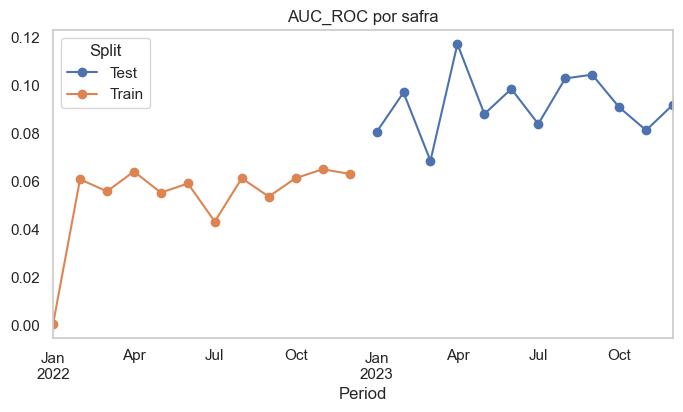

In [101]:
# Ex.: plotar MCC ao longo do tempo
(
    metrics_by_vintage["AUC_ROC"]
    .unstack(level="Split")
    .plot(marker="o", figsize=(8,4), title="AUC_ROC por safra").grid(visible=False)
)

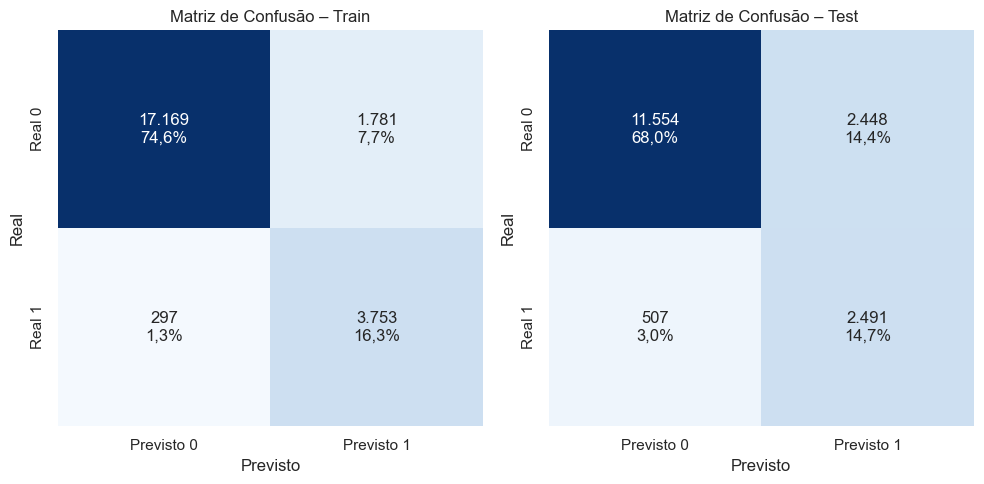

In [102]:
evaluator.plot_confusion(
    splits=["train",'test']
    )

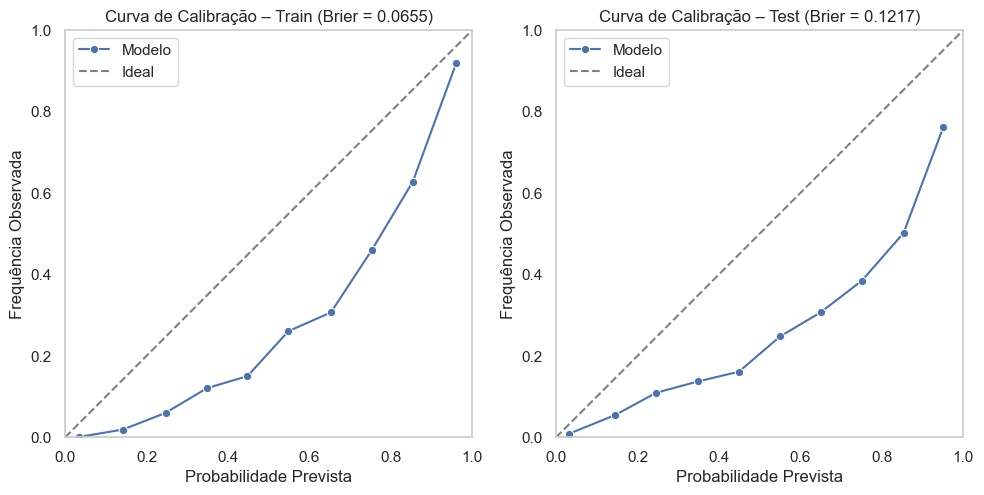

In [103]:
evaluator.plot_calibration(
    splits=["train",'test']
    )

In [ ]:
# hover text nao foi melhorado

#evaluator.plot_event_rate()

In [ ]:
# falta aplicar a separação por graficos com parametro features
# feature='acc_open_past_24_mths'

#evaluator.plot_psi()

In [104]:
evaluator.plot_ks()

In [105]:
evaluator.plot_group_radar()

In [106]:
evaluator.plot_decile_ks()

### Teste de Stress

In [ ]:
gen = LookAhead(id_cols=['id'], date_cols=['date']).fit(train)
evaluator.synthetic_gen = gen
stress = evaluator.run_stress_test()
stress['metrics']